## Test-set results

In this notebook we will check the results on the test set that contains 8 balanced classes of 100 samples each.


### Contents
---

- [Requirements](#requirements)
- [Running the Model on the test set](#runtest)
- [Classification Report](#classreport)
- [Results analysis](#resanal)
- [Generating class labels](#classlabels)
---



<a id='requirements'></a>
### Requirements

---

These are the requirements for this notebook.

The convolutional models should be in the same directory as this notebook in order for this to work. 
The images should also be processed beforehand. See ```Initial loading of X and Y.ipynb``` for how I generated it.

Required Files:
```
* Image files in the 'test' folder
* resnet50model.h5
* y.pickle
* classlabels.pickle
```

Required Packages:
```
* sklearn
* librosa
* pandas
* numpy
* keras
* matplotlib.pyplot

```

__The ResNet model is used here for the predictor model and was loaded from ```resnet50model.h5``` that was previously saved. __


In [1]:
import numpy as np
from keras.models import load_model
import pickle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
classlabels = pickle.load(open('classlabels.pickle', 'rb'))
print(classlabels)


['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']


In [3]:
y = pickle.load(open('y.pickle', 'rb'))  # true class labels from the dataset
print(y['067600'])

[0 0 1 0 0 0 0 0]


In [4]:
conv3 = load_model('resnet50model.h5')

In [5]:
conv3.model.summary()    # Full Model Summary

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 200, 1024, 3)  0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 206, 1030, 3)  0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 100, 512, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 100, 512, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

---
<a id='requirements'></a>
### Running the model on the test set
Generating predictions here.

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('test/', target_size = (200,1024), batch_size = 100,
                                                 class_mode = None, shuffle=False)
filenames = test_generator.filenames # Get true labels

predictions = conv3.model.predict_generator(test_generator,steps=8, max_queue_size=1, workers=1, use_multiprocessing=False)

Found 800 images belonging to 8 classes.


In [7]:
predictions.shape

(800, 8)

In [8]:
filenames[:3]

['Electronic/046159.jpeg', 'Electronic/033221.jpeg', 'Electronic/048464.jpeg']

In [9]:
labels = []   #labels of the testset
index = []    # file id of the testset
for filename in filenames:
    labels.append(filename[:-12])
    index.append(filename[-11:-5])

In [10]:
groundtrutharray = []
groundtruth = []  #index of genre
for ind in index:
    groundtruthelement = y[ind]
    groundtrutharray.append(groundtruthelement)
    groundtruth.append(np.argmax(groundtruthelement))

In [11]:
print(predictions.shape)
print(predictions)

(800, 8)
[[  2.99969073e-02   1.19329281e-01   2.26203296e-02 ...,   2.42751554e-01
    3.38165760e-01   8.36573914e-02]
 [  2.63165772e-01   2.10771829e-01   9.30955357e-05 ...,   1.68222432e-05
    3.85761201e-01   1.38666388e-02]
 [  1.15972301e-02   3.53990972e-01   1.09267356e-04 ...,   1.20595498e-04
    6.12482131e-01   6.73546856e-06]
 ..., 
 [  5.58522064e-03   7.19827339e-02   1.43687055e-02 ...,   8.99966748e-04
    9.55060422e-02   8.10741425e-01]
 [  1.61754753e-04   2.30068751e-02   2.86565046e-04 ...,   3.73350304e-05
    9.23473481e-03   9.33902562e-01]
 [  7.29206717e-03   1.70157999e-01   8.78056511e-03 ...,   6.21685013e-02
    6.88896894e-01   4.01972942e-02]]


---
As the softmax classifier gives a range of predicted probabilities for the dataset, I decided to get the max value as the top predictions.

In [12]:
maxpredictions = [np.argmax(p) for p in predictions] # getting the indices for the top predictor

top3 = [np.argsort(p, axis=0)[-3:] for p in predictions]    # top 3

groundtrutharray = np.array(groundtrutharray)    # actual labels

In [13]:
# This forces the prediction array to output 1 for the top class prediction and 0 for the rest.
predtest = predictions.copy()
predict = []
for pred in predtest:
    pred[np.argmax(pred)] = 1
    predict.append(np.array([int(p) for p in pred]))
    
predict = np.array(predict)

---
<a id='classreport'></a>
### Classification Report.

Electronic, Folk, Hip-Hop, and International music had f1 scores above 0.5... Pop and experimental music doesn't do too well.

In [14]:
print("Classification Report:")
print(classification_report(groundtrutharray,predict, target_names = classlabels))

Classification Report:
               precision    recall  f1-score   support

   Electronic       0.51      0.65      0.57       100
 Experimental       0.35      0.47      0.40       100
         Folk       0.51      0.32      0.39       100
      Hip-Hop       0.67      0.53      0.59       100
 Instrumental       0.66      0.43      0.52       100
International       0.50      0.58      0.54       100
          Pop       0.27      0.24      0.26       100
         Rock       0.43      0.56      0.49       100

  avg / total       0.49      0.47      0.47       800



Let's look at Electronic Music and Pop and why one is so good and the other is so bad.

---
<a id='resanal'></a>
### Results analysis

Let us create a dataframe to perform better analysis of the results.

In [15]:
classifications = []    # making a list to see if the classifier predicted the top class correctly or not
isintop3 = []           # another list to see if the true label is in the top 3 predictions.
for i,_ in enumerate(predict):
    if sum(predict[i] == groundtrutharray[i]) == 8:
        classifications.append(True)
    elif sum(predict[i] == groundtrutharray[i]) == 6:
        classifications.append(False)
    if groundtruth[i] in top3[i]:
        isintop3.append(True)
    else:
        isintop3.append(False)

In [16]:
df = pd.DataFrame(predictions*100, columns=classlabels, index = index)   # multiplied predictions by 100 for easy view
# Making new columns to put in appended data
df['label'] = labels
df['top1'] = classifications
df['top3'] = isintop3
df['predicted'] = classlabels[maxpredictions]

In [17]:
df.head(10)    

,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock,label,top1,top3,predicted
046159,2.999691,11.932928,2.262033e+00,15.019746,1.328137,24.275156,33.816574,8.365739,Electronic,False,False,Pop
033221,26.316578,21.077183,9.309554e-03,0.005992,12.626472,0.001682,38.576118,1.386664,Electronic,False,True,Pop
048464,1.159723,35.399097,1.092674e-02,0.000030,2.169273,0.012060,61.248215,0.000674,Electronic,False,False,Pop
047071,99.839043,0.160460,1.705989e-08,0.000442,0.000016,0.000005,0.000043,0.000002,Electronic,True,True,Electronic
042374,94.128197,0.056998,2.827665e-06,4.321452,0.000135,0.013124,1.480088,0.000012,Electronic,True,True,Electronic
042377,40.533329,3.859601,1.408049e-01,36.926754,0.879098,0.681193,16.649746,0.329480,Electronic,True,True,Electronic
051923,12.215757,17.421644,3.612159e-01,2.707130,26.646101,3.736725,11.414940,25.496492,Electronic,False,False,Instrumental
045100,99.700073,0.239574,4.396014e-05,0.021100,0.013922,0.015469,0.006588,0.003230,Electronic,True,True,Electronic
036145,8.541430,43.847839,1.858301e-04,0.088525,47.429249,0.007599,0.027897,0.057285,Electronic,False,True,Instrumental
048463,0.156738,6.302401,1.742509e+00,0.279715,0.179129,2.422962,87.103531,1.813017,Electronic,False,False,Pop


---
Here I created a copy of the dataframe to force the predictions to be integers for better viewing.

In [18]:
df2 = df.copy()
df2.iloc[:,0:8] = df2.iloc[:,0:8].applymap(lambda x: int(x))

Let's look at some of the predictions to see why the accuracy is so low.

For this cell, I chose predictions where I identified the track to be a Rock song and it was misclassified.

In [19]:
df2.loc[(df2['label'] != 'Rock') & (df2['top1'] == False)].sort_values('Rock', ascending=False).head()

,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock,label,top1,top3,predicted
045154,0,0,0,0,0,0,0,99,Electronic,False,False,Rock
080517,0,2,0,0,0,0,0,96,Instrumental,False,False,Rock
021677,0,1,0,0,0,0,3,95,Pop,False,True,Rock
080516,0,0,0,5,0,0,0,94,Instrumental,False,True,Rock
024424,0,0,0,1,0,0,4,93,Hip-Hop,False,True,Rock


---
Granted, upon listening to these tracks, 045154 seems to be a misclassified song. I could still see how it could be mistaken for a rock song, but I think it is just my bias talking here.

Track 021677 is a bit ambiguous. Definitely in the grey area but the second highest prediction for the classifier was Pop. At least it's in the top 3.

Same for track 024424. Top 3 is alright. I could definitely hear some rock elements.

Tracks 080517 and 080516 are interesting though. Listening to it, I would say that it definitely is a rock song without a doubt. Something is working well for my classifier. Maybe my low accuracy rate is because of 'mislabelling'?

---

Let's look at international songs. I am quite curious as to what 'constitutes' an International song and what the diference between them and other genres could be. Let's see:

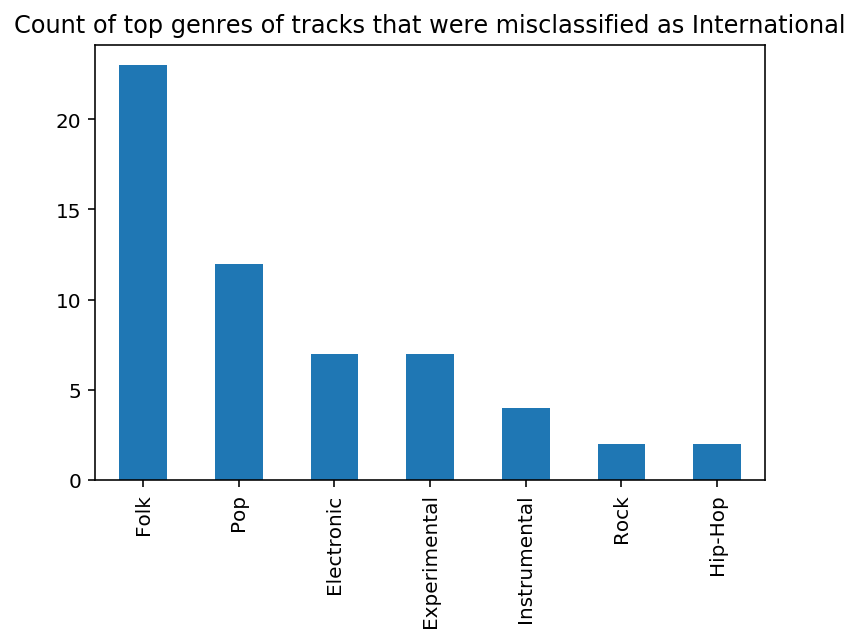

In [20]:
df2.loc[(df2['label'] != 'International') & (df2['predicted'] == 'International')] \
.sort_values('International', ascending=False)['label'].value_counts().plot.bar \
(title = 'Count of top genres of tracks that were misclassified as International')

Apparently most Folk songs are being misclassified as International songs. Interesting...

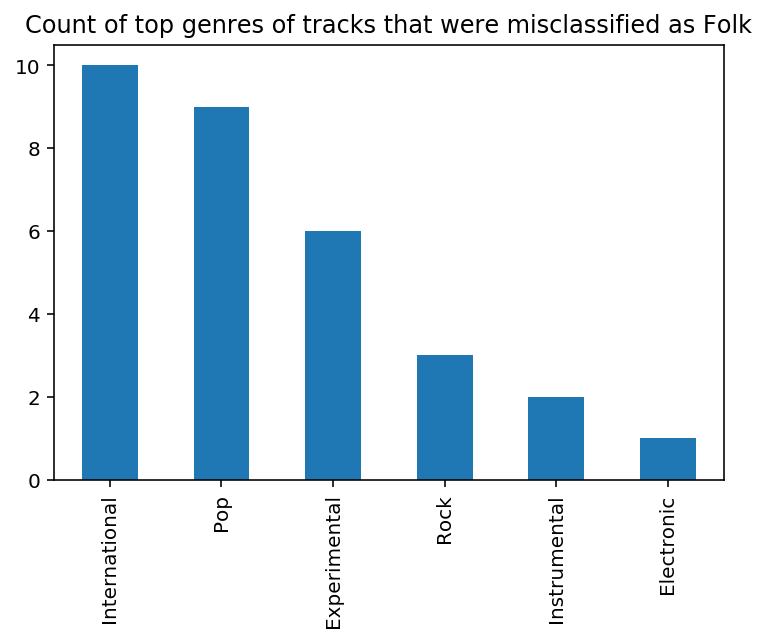

In [21]:
df2.loc[(df2['label'] != 'Folk') & (df2['predicted'] == 'Folk')] \
.sort_values('Folk', ascending=False)['label'].value_counts().plot.bar \
(title = 'Count of top genres of tracks that were misclassified as Folk')

International and Pop songs are being misclassified as Folk songs. There should be some relation between them. Interestingly, no Hip-Hop songs were misclassified as Folk. Makes sense...

Pop performed poorly. Let's see why:

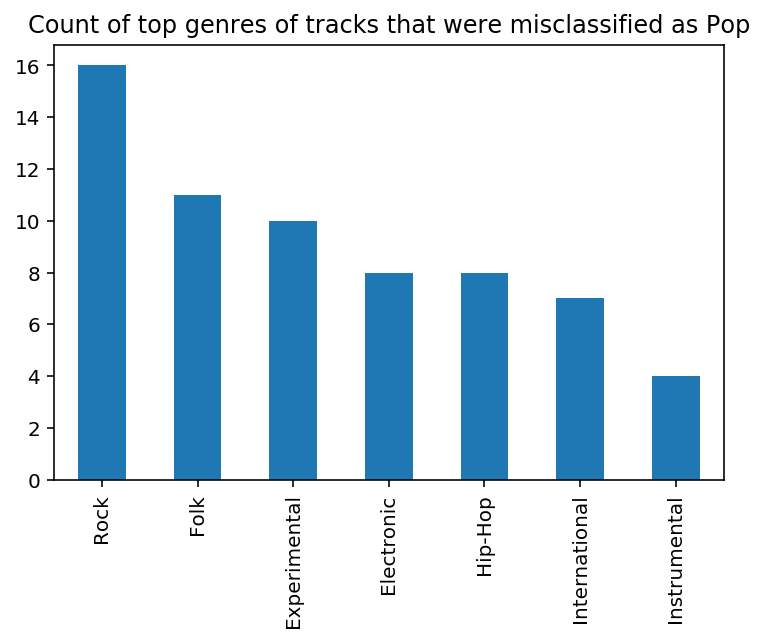

In [22]:
df2.loc[(df2['label'] != 'Pop') & (df2['predicted'] == 'Pop')] \
.sort_values('Pop', ascending=False)['label'].value_counts().plot.bar \
(title = 'Count of top genres of tracks that were misclassified as Pop')

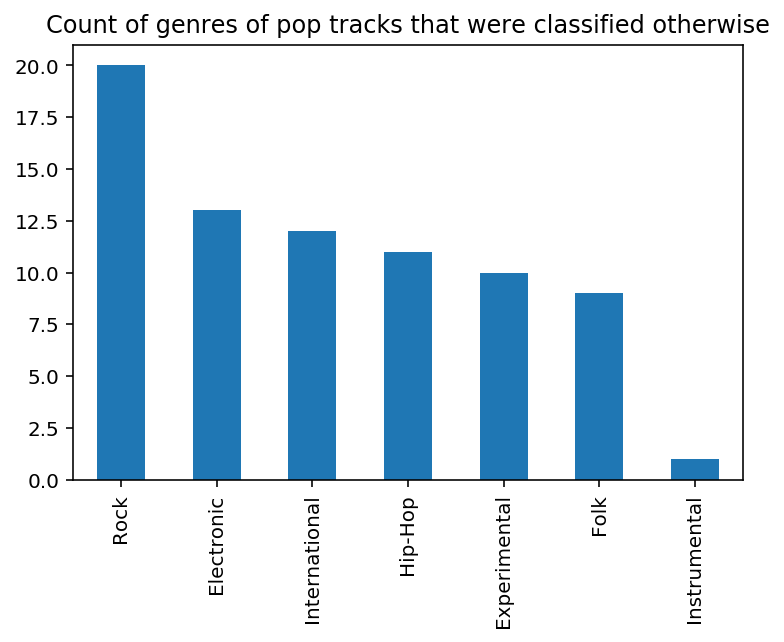

In [26]:
df2.loc[(df2['label'] == 'Pop') & (df2['predicted'] != 'Pop')] \
.sort_values('Pop', ascending=True)['predicted'].value_counts().plot.bar \
(title = 'Count of genres of pop tracks that were classified otherwise')

It seems that instrumental songs are rarely ever considered pop songs, but the distribution looks similar for the rest of the genres (barring Rock songs). This means that the pop genre is more of a meta-genre than other genres, with elements from every other genre being  

Let's look at Instrumental tracks.

In [32]:
df2.loc[df2['top3'] == False].sort_values('Instrumental', ascending=False).head()

,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock,label,top1,top3,predicted
027866,0,0,0,0,99,0,0,0,Experimental,False,False,Instrumental
026301,0,0,1,0,95,1,0,0,Experimental,False,False,Instrumental
036245,2,6,0,0,87,0,1,2,Electronic,False,False,Instrumental
024367,5,0,0,10,76,3,0,3,International,False,False,Instrumental
026011,16,8,0,0,74,0,0,0,Hip-Hop,False,False,Instrumental


Interesting. Even when the true label doesn't classify it as an instrumental song, the model still picks up the fact that there are no voices in the sample to classify it as an instrumental song, based on this sample size.

#### This is the accuracy of the model if the top 3 predicted genres are the ground truth!

This is quite much better than the top1 accuracy of 45%

In [29]:
print("This is the top1 accuracy:", df2['top1'].sum()/df2['top1'].count())
print( "This is the top3 accuracy:",df2['top3'].sum()/df2['top3'].count())

This is the top1 accuracy: 0.4725
This is the top3 accuracy: 0.77375


In [33]:
predictionsdf = pd.DataFrame(predictions*100, columns=classlabels, index = index)

In [34]:
predictionsdf.head()

,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock
046159,2.999691,11.932928,2.262033e+00,15.019746,1.328137,24.275156,33.816574,8.365739
033221,26.316578,21.077183,9.309554e-03,0.005992,12.626472,0.001682,38.576118,1.386664
048464,1.159723,35.399097,1.092674e-02,0.000030,2.169273,0.012060,61.248215,0.000674
047071,99.839043,0.160460,1.705989e-08,0.000442,0.000016,0.000005,0.000043,0.000002
042374,94.128197,0.056998,2.827665e-06,4.321452,0.000135,0.013124,1.480088,0.000012


In [37]:
def similarityscore(song1,song2):
    np1 = np.array(song1)
    np2 = np.array(song2)
    difference = (np1 - np2)**2
    
    return sum(difference)



def dynamicscore(song1, recdf):
    song1 = recdf.loc[song1]
    errorlist = []
    for i in range(recdf.shape[0]):
        error = similarityscore(song1, recdf.iloc[i])
        errorlist.append((recdf.index[i], error))
    return errorlist
    
elist = dynamicscore('081792', predictionsdf)
sorted(elist, key=lambda tup: tup[1])[1:]

[('081781', 0.0093553911880988605),
 ('087099', 0.083808419764238806),
 ('086486', 0.203854129196543),
 ('081999', 0.64257261042754943),
 ('027866', 1.3404483609753037),
 ('087101', 3.6892471895225754),
 ('081814', 4.7357875258711761),
 ('086484', 11.643056099522724),
 ('086485', 13.867072381251758),
 ('087104', 14.497313098876475),
 ('086483', 21.002599915845167),
 ('026301', 31.049274837947451),
 ('081523', 34.770229531838844),
 ('087098', 53.670224822330056),
 ('086481', 61.74076435110976),
 ('087105', 97.450965435429339),
 ('083612', 130.09211767202237),
 ('081436', 145.8594903250866),
 ('092953', 176.33118750515692),
 ('036245', 216.35687084812344),
 ('087100', 251.43207482581784),
 ('083600', 256.14615769078955),
 ('090526', 299.21544959892361),
 ('081650', 315.26579972989202),
 ('081600', 360.74386697043741),
 ('035444', 426.92983963068582),
 ('082929', 534.94956078194082),
 ('024367', 713.68629645463079),
 ('087107', 923.00055214474742),
 ('026011', 1017.7557377110297),
 ('0905